# **멀티라벨 분류**

4가지의 이미지를 분류해본다

기본적인 방법은 단일 이미지 분류와 같다. 대신, 다중 이미지 분류이기 때문에 카테고리의 변화가 있다.


## 1번 train

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = '/content/drive/My Drive/CTRC/train'
categories = ["1. Cancer","2. Precancer","3. Extra","4. Normal"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories): #cat은 그냥 
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat #cat은 그냥
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save('/content/drive/My Drive/CTRC/train/multi_image_data.npy', xy)

print("ok", len(y))


1. Cancer  파일 길이 :  368
1. Cancer  :  /content/drive/My Drive/CTRC/train/1. Cancer/can_40.jpg
2. Precancer  파일 길이 :  110
2. Precancer  :  /content/drive/My Drive/CTRC/train/2. Precancer/precan_42.jpg
3. Extra  파일 길이 :  206
3. Extra  :  /content/drive/My Drive/CTRC/train/3. Extra/inf_37.jpg
4. Normal  파일 길이 :  398
4. Normal  :  /content/drive/My Drive/CTRC/train/4. Normal/nor_153.jpg
ok 1082


이제 numpy 데이터를 불러온다. 저것을 가지고 학습!

In [ ]:
import os, glob, numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K


import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

X_train, X_test, y_train, y_test = np.load('/content/drive/My Drive/CTRC/train/multi_image_data.npy', allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

(811, 64, 64, 3)
811


In [ ]:
'''!pip uninstall keras
!pip install Keras==2.2.4'''

'!pip uninstall keras\n!pip install Keras==2.2.4'

In [ ]:
categories = ["1. Cancer","2. Precancer","3. Extra","4. Normal"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [ ]:

with K.tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten()) 
    #CNN에서 컨볼루션 레이어나 맥스풀링을 거치면 주요 특징만 추출되어 학습됨
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    
    

In [ ]:
'''!pip uninstall tensorflow
!pip install tensorflow==1.13.1'''

'!pip uninstall tensorflow\n!pip install tensorflow==1.13.1'

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
__________

In [ ]:

#데이터셋이 적어서 validation을 그냥 test 데이터로 했습니다. 
#데이터셋이 충분하시면 이렇게 하시지 마시고 validation_split=0.2 이렇게 하셔서 테스트 셋으로 나누길 권장

history = model.fit(X_train, y_train, batch_size=32, epochs=50, 
                    validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 811 samples, validate on 271 samples
Epoch 1/50
811/811 [==============================] - 11s 13ms/step - loss: 1.4712 - acc: 0.4106 - val_loss: 1.1777 - val_acc: 0.6310

Epoch 00001: val_loss improved from inf to 1.17767, saving model to ./model/multi_img_classification.model
Epoch 2/50
811/811 [==============================] - 10s 12ms/step - loss: 1.1889 - acc: 0.5302 - val_loss: 1.1334 - val_acc: 0.6052

Epoch 00002: val_loss improved from 1.17767 to 1.13341, saving model to ./model/multi_img_classification.model
Epoch 3/50
811/811 [==============================] - 10s 12ms/step - loss: 1.1261 - acc: 0.5635 - val_loss: 1.0017 - val_acc: 0.6421

Epoch 00003: val_loss improved from 1.13341 to 1.00167, saving model to ./model/multi_img_classification.model
Epoch 4/50
811/811 [==============================] - 10s 12ms/step - loss: 1.0850 - acc: 0.5635 - val_loss: 0.9772 - val_acc: 0.6494

Epoch 00004: val_loss improved from 1.00167 to 0.97718, saving model to ./model/multi

In [ ]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

271/271 [==============================] - 1s 4ms/step
정확도 : 0.6531


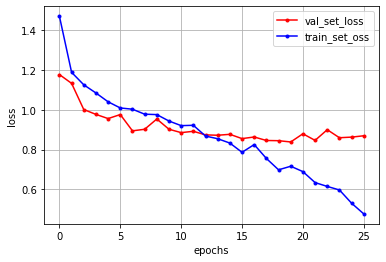

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "/content/drive/My Drive/CTRC/train/multi_img_data/imgs_others_test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3


#테스트할 이미지를 변환할 소스
X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = image.open(f)         #######################에
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
X = X.reshape(X.shape[0], 64,64,3)
model = load_model( './model/multi_img_classification.model')


#해당 이미지 predict
prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0


print(X.shape)

(0, 64, 64, 3)


In [ ]:
'''import tensorflow as tf
print(tf.__version__)'''

1.13.1


이제 파일 비교해서 결과내기 코드

In [ ]:
#훈련된 모델을 이용해 한 이미지에 대한 예측 만들기

# 테스트 세트에서 이미지 하나를 선택합니다
img = X_test[0]

print(img.shape)
print(img)

(64, 64, 3)
[[[0.278 0.169 0.184]
  [0.282 0.161 0.180]
  [0.282 0.165 0.180]
  ...
  [0.498 0.337 0.392]
  [0.498 0.337 0.392]
  [0.482 0.333 0.384]]

 [[0.294 0.173 0.196]
  [0.298 0.173 0.196]
  [0.294 0.173 0.188]
  ...
  [0.498 0.329 0.384]
  [0.494 0.333 0.388]
  [0.494 0.341 0.392]]

 [[0.310 0.180 0.208]
  [0.325 0.192 0.220]
  [0.322 0.188 0.208]
  ...
  [0.486 0.322 0.376]
  [0.502 0.337 0.396]
  [0.510 0.349 0.408]]

 ...

 [[0.380 0.180 0.169]
  [0.380 0.180 0.169]
  [0.380 0.180 0.169]
  ...
  [0.451 0.251 0.243]
  [0.463 0.251 0.251]
  [0.459 0.251 0.251]]

 [[0.373 0.180 0.165]
  [0.376 0.180 0.169]
  [0.376 0.180 0.173]
  ...
  [0.459 0.255 0.251]
  [0.463 0.263 0.259]
  [0.463 0.271 0.267]]

 [[0.369 0.180 0.169]
  [0.369 0.180 0.173]
  [0.369 0.176 0.173]
  ...
  [0.443 0.251 0.247]
  [0.451 0.259 0.255]
  [0.447 0.263 0.255]]]


In [ ]:
#이 파일의 예측

img=np.resize(img,(1,64,64,3))
predictions_single = model.predict(img)

print(predictions_single)

[[0.004 0.002 0.011 0.983]]


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


imageGenerator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    brightness_range=[.2,.2],
                                    horizontal_flip=True,
                                    validation_split=.1)

In [ ]:

testGenerator = ImageDataGenerator(
    rescale=1./255
)

#데이터가 충분하지 않아서

testGen = imageGenerator.flow_from_directory('/content/drive/My Drive/CTRC/train', target_size=(64, 64))



#데이터가 충분하면 나누기
'''trainGen = imageGenerator.flow_from_directory('/content/drive/My Drive/CTRC/train'),
                                              target_size=(64,64),
                                              subset='training')

validationGen = imageGenerator.flow_from_directory('/content/drive/My Drive/CTRC/train'),
                                                  target_size=(64,64),
                                                  subset='validation')'''

Found 1797 images belonging to 4 classes.


"trainGen = imageGenerator.flow_from_directory('/content/drive/My Drive/CTRC/train'),\n                                              target_size=(64,64),\n                                              subset='training')\n\nvalidationGen = imageGenerator.flow_from_directory('/content/drive/My Drive/CTRC/train'),\n                                                  target_size=(64,64),\n                                                  subset='validation')"

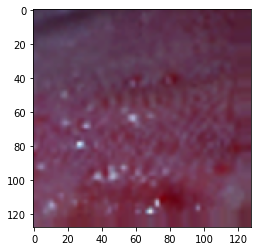

In [ ]:

from tensorflow.keras.preprocessing.image import array_to_img
import numpy as np

cls_index = ['1. Cancer', '2. Precancer','3. Extra','4. Normal']

imgs = testGen.next()
arr = imgs[0][0]


img = array_to_img(arr).resize((128, 128))
plt.imshow(img)


모델 예측하기

In [ ]:
print(img)

<PIL.Image.Image image mode=RGB size=128x128 at 0x7F38BDDF2F28>


예측: 3. Extra
<PIL.Image.Image image mode=RGB size=128x128 at 0x7F38BDDF2F28>


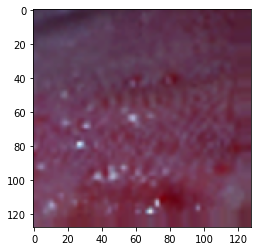

In [ ]:

result = model.predict_classes(arr.reshape(1,64,64,3))

plt.imshow(img)
print('예측: {}'.format(cls_index[result[0]]))
print(img)



# np.argmax: 다차원 배열의 경우에 차원에 따라 가장 큰 값의 인덱스들을 반환
# format: 문자열에 포함된 대괄호 개수 보다 format안에 들어 있는 값의 수가 적으면 에러

#### 이미지 정답은 어떻게 불러오지


예측: 3. Extra
Label:[0 0 0 1]
<PIL.Image.Image image mode=RGB size=128x128 at 0x7F38BDDF2F28>


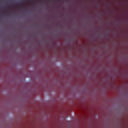

In [ ]:
print('예측: {}'.format(cls_index[result[0]]))
print("Label:" + str(y_test[0]) )
print(img)
img

In [ ]:
'''if np.max(y_test)==0:
  print(cls_index[0])
if np.max(y_test)==1:
  print(cls_index[1])
if np.max(y_test)==2:
  print(cls_index[2])
else:
  print(cls_index[3])'''

'if np.max(y_test)==0:\n  print(cls_index[0])\nif np.max(y_test)==1:\n  print(cls_index[1])\nif np.max(y_test)==2:\n  print(cls_index[2])\nelse:\n  print(cls_index[3])'

#### **validation data와 test data가 나뉘어져 있지 않음.**


데이터가 충분하다면 꼭 나누기

In [ ]:
'''trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath,'training_set'),
                                              target_size=(64,64),
                                              subset='training')

validationGen = imageGenerator.flow_from_directory(os.path.join(rootPath,'training_set'),
                                                  target_size=(64,64),
                                                  subset='validation')'''






'''trainGen = imageGenerator.flow_from_directory('/content/drive/My Drive/CTRC/train'),
                                              target_size=(64,64),
                                              subset='training')

validationGen = imageGenerator.flow_from_directory('/content/drive/My Drive/CTRC/train'),
                                                  target_size=(64,64),
                                                  subset='validation')'''
                                              

# 2번 full data test

In [ ]:
caltech_dir = '/content/drive/My Drive/CTRC/test'
categories = ["1. Cancer","2. Precancer","3. Extra","4. Normal"]

test=[]
test = np.array(test)

model = load_model( './model/multi_img_classification.model')
predict = model.predict_classes(test)

for i in range(len(test)):
    print(name[i] + " : , Predict : "+ str(categories[predict[i]]))
